<a href="https://colab.research.google.com/github/immischein/ML-bandgap/blob/main/datafor3elements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# You might need to reinstall the library manually, imports ans pip install:
!pip install mp_api
!pip install pymatgen

  Using cached mp_api-0.45.5-py3-none-any.whl.metadata (2.3 kB)
  Using cached maggma-0.71.5-py3-none-any.whl.metadata (11 kB)
  Using cached emmet_core-0.84.7rc1-py3-none-any.whl.metadata (3.0 kB)
  Using cached pydantic_settings-2.9.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pybtex-0.24.0-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached pymongo-4.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (22 kB)
  Using cached mongomock-4.3.0-py2.py3-none-any.whl.metadata (12 kB)
  Using cached pydash-8.0.5-py3-none-any.whl.metadata (4.5 kB)
  Using cached jsonlines-4.0.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached aioitertools-0.12.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyzmq-26.4.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.0 kB)
  Using cached dnspython-2.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached sshtunnel-0.4.0-py2.py3-none-any.whl.metadata (19 kB)
  Using cached boto3-1.38.22-py3-none-any.whl.metadata (6.6 kB)
  P

In [7]:
# Import
from mp_api.client import MPRester
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import json
from pymatgen.core.structure import Structure
import matplotlib.pyplot as plt
import seaborn as sns
from pymatgen.core.composition import Composition
from pymatgen.core.periodic_table import Element
import time

In [8]:
with MPRester("VlQ1oWGAXlhWiKRkPOk5q1cP8dNS6mIu") as mpr:
  #Please edit features you want to filter from inside the search() command. for example:
  example_docs3 = mpr.materials.summary.search(num_elements = 3, band_gap=(.001, None))


Retrieving SummaryDoc documents:   0%|          | 0/28117 [00:00<?, ?it/s]

In [9]:
def one_hot_orbital(orbital: str, max_orbitals="spdfghijklmno") -> list:
    """
    Return a one-hot encoded vector for a given orbital type.

    Parameters:
    orbital (str): A single orbital character (e.g., 's', 'p', 'd', ...)
    max_orbitals (str): Ordered string of all orbital types to consider.

    Returns:
    list: One-hot encoded vector
    """
    orbital = orbital.lower()
    if orbital not in max_orbitals:
        raise ValueError(f"Orbital '{orbital}' not recognized in '{max_orbitals}'")

    index = max_orbitals.index(orbital)
    vec = [0] * len(max_orbitals)
    vec[index] = 1
    return vec

In [12]:
from collections import defaultdict

def analyze_missing_electrons_with_index(orbitals):
    """
    Analyze orbital data and return the orbital with the most missing electrons, including index info.

    Parameters:
    orbitals (list of tuples): Each tuple is (n, orbital_type, electron_count)

    Returns:
    dict: Dictionary containing all missing counts (with indexes) and the orbital with the most missing electrons.
    """
    # Maximum electron capacities
    orbital_max = {
    's': 2,
    'p': 6,
    'd': 10,
    'f': 14
}

    # Calculate missing electrons with index tracking
    missing_electrons = []
    for i, (n, orbital_type, count) in enumerate(orbitals):
        max_e = orbital_max[orbital_type]
        missing = max_e - count
        missing_electrons.append({
            "index": i,
            "n": n,
            "orbital": orbital_type,
            "missing": missing
        })

    # Find the orbital with the most missing electrons
    most_missing = max(missing_electrons, key=lambda x: x["missing"])

    # Prepare the result
    result = {
        "all_missing": missing_electrons,
        "most_missing": most_missing
    }

    return result

In [15]:
def function_orbital_info(Element_number):
  el = Element.from_Z(Element_number)
  config = el.full_electronic_structure
  orbitals = [(orb,l, e) for orb, l, e in config]
  analyse = analyze_missing_electrons_with_index(orbitals)['most_missing']
  most_missing_electrons_orbital = analyse['missing']
  missing_orbital = analyse['orbital']
  missing_orbital_onehot = one_hot_orbital(missing_orbital)
  if el.atomic_orbitals != None:
    orbital_energy = list(el.atomic_orbitals.values())[analyse['index']]
  else:
    orbital_energy = 0
  return orbital_energy, missing_orbital_onehot, most_missing_electrons_orbital, missing_orbital


In [26]:
start = time.time()

# Build tabular dataset
records = []
for m in example_docs3:

    struct = m.structure
    elements = set(m.structure.species)
    elements = list(elements)
    element1 = Element(elements[0]).Z
    element2 = Element(elements[1]).Z
    element3 = Element(elements[2]).Z


    # electronegativity
    en_values = [Element(el).X for el in elements]
    min_en_values = np.min(en_values)
    max_en_values = np.max(en_values)

    #ie
    ie_values = [Element(el).ionization_energy for el in elements]
    min_ie_values = np.min(ie_values)
    max_ie_values = np.max(ie_values)

    #am
    am_values = [Element(el).atomic_mass for el in elements]
    min_am_values = np.min(am_values)
    max_am_values = np.max(am_values)

    #vdw
    vdw_values = [Element(el).van_der_waals_radius for el in elements]
    min_vdw_values = np.min(vdw_values)
    max_vdw_values = np.max(vdw_values)

    a1,b1,c1,d1 = function_orbital_info(element1)
    a2,b2,c2,d2 = function_orbital_info(element2)
    a3,b3,c3,d3 = function_orbital_info(element3)

    record = {
        "band_gap": m.band_gap,
        "material_id": m.material_id,
        "elements": elements,
        "element1": element1,
        "element2": element2,
        "element3": element3,

        "molar_volume_1": Element.from_Z(element1).molar_volume,
        "molar_volume_2": Element.from_Z(element2).molar_volume,
        "molar_volume_3": Element.from_Z(element3).molar_volume,
        "sum_molar_volume": Element.from_Z(element1).molar_volume + Element.from_Z(element2).molar_volume + Element.from_Z(element3).molar_volume,
        "mean_molar_volume": (Element.from_Z(element1).molar_volume + Element.from_Z(element2).molar_volume + Element.from_Z(element3).molar_volume)/3,
        "std_molar_volume": np.std([Element.from_Z(element1).molar_volume, Element.from_Z(element2).molar_volume, Element.from_Z(element3).molar_volume]),

        "van_der_waals_radius_1": Element.from_Z(element1).van_der_waals_radius,
        "van_der_waals_radius_2": Element.from_Z(element2).van_der_waals_radius,
        "van_der_waals_radius_3": Element.from_Z(element3).van_der_waals_radius,

        "atomic_radius_1": Element.from_Z(element1).atomic_radius,
        "atomic_radius_2": Element.from_Z(element2).atomic_radius,
        "atomic_radius_3": Element.from_Z(element3).atomic_radius,

        "atomic_mass_1": Element.from_Z(element1).atomic_mass,
        "atomic_mass_2": Element.from_Z(element2).atomic_mass,
        "atomic_mass_3": Element.from_Z(element3).atomic_mass,

        "ionization_energy_1": Element.from_Z(element1).ionization_energy,
        "ionization_energy_2": Element.from_Z(element2).ionization_energy,
        "ionization_energy_3": Element.from_Z(element3).ionization_energy,

        "electron_affinity_1": Element.from_Z(element1).electron_affinity,
        "electron_affinity_2": Element.from_Z(element2).electron_affinity,
        "electron_affinity_3": Element.from_Z(element3).electron_affinity,

        "electronegativity_1": Element.from_Z(element1).X,
        "electronegativity_2": Element.from_Z(element2).X,
        "electronegativity_3": Element.from_Z(element3).X,

        "orbital_energy_1": a1,
        "orbital_energy_2": a2,
        "orbital_energy_3": a3,

        "largest_with_most_missing_electron_orbital_1": b1,
        "largest_with_most_missing_electron_orbital_2": b2,
        "largest_with_most_missing_electron_orbital_3": b3,

        "most_missing_electrons_orbital_1": c1,
        "most_missing_electrons_orbital_2": c2,
        "most_missing_electrons_orbital_3": c3,

        "categorical_orbital_1" : d1,
        "categorical_orbital_2" : d2,
        "categorical_orbital_3" : d3,

        "density": m.density,
        "energy_per_atom": m.energy_per_atom,
        "volume": m.volume,

        "a": struct.lattice.a,
        "b": struct.lattice.b,
        "c": struct.lattice.c,
        "alpha": struct.lattice.alpha,
        "beta": struct.lattice.beta,
        "gamma": struct.lattice.gamma,
        "n_atoms": struct.num_sites,

        "mean_distance": np.mean(struct.distance_matrix[0][1:]),
        "max_distance": np.max(struct.distance_matrix[0]),
        "min_distance": np.sort(struct.distance_matrix[0])[1], # taking second smallest distance, because distance to self is always 0
        "std_distance": np.std(struct.distance_matrix[0][1:]),
        "spacegroup_number " : struct.get_space_group_info()[1],

        #"electronegativities": en_data,
        "avg_en": np.mean(en_values),
        "en_range": max_en_values - min_en_values,
        "max_en": max_en_values,
        "min_en": min_en_values,
        "std_en": np.std(en_values),

        "avg_ie": np.mean(ie_values),
        "ie_range": max_ie_values - min_ie_values,
        "max_ie": max_ie_values,
        "min_ie": min_ie_values,
        "std_ie": np.std(ie_values),

        "avg_am": np.mean(am_values),
        "en_range": max_am_values - min_am_values,
        "max_am": max_am_values,
        "min_am": min_am_values,
        "std_am": np.std(am_values),

        "avg_vdw": np.mean(vdw_values),
        "vdw_range": max_vdw_values - min_vdw_values,
        "max_vdw": max_vdw_values,
        "min_vdw": min_vdw_values,
        "std_vdw": np.std(vdw_values)

    }
    records.append(record)

end = time.time()

print(f"Execution time: {end - start:.4f} seconds")

# df = pd.DataFrame(records)
# df.to_csv("bandgap_dataset.csv", index=False)

# print(f"Saved tabular dataset to bandgap_dataset.csv with shape {df.shape}")

<ipython-input-15-ee5f554a4a3d>:9: UserWarning: No data available for atomic_orbitals for Pu
  if el.atomic_orbitals != None:
<ipython-input-15-ee5f554a4a3d>:9: UserWarning: No data available for atomic_orbitals for Np
  if el.atomic_orbitals != None:
<ipython-input-26-333bffe025d4>:16: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  en_values = [Element(el).X for el in elements]
<ipython-input-26-333bffe025d4>:75: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  "electronegativity_2": Element.from_Z(element2).X,


Execution time: 197.0266 seconds


In [27]:
df = pd.DataFrame(records)
df.to_csv("dataset3elements2.csv", index=False)
print(f"Saved tabular dataset to bandgap_dataset.csv with shape {df.shape}")

Saved tabular dataset to bandgap_dataset.csv with shape (28117, 76)


In [19]:
df

,band_gap,material_id,elements,element1,element2,element3,molar_volume_1,molar_volume_2,molar_volume_3,van_der_waals_radius_1,...,std_ie,avg_am,max_am,min_am,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw
0,0.0794,mp-867311,"[Ac, Te, Ag]",89,52,47,22.55,20.46,10.27,2.47,...,1.492628,154.156067,227.00000,107.8682,52.134537,2.213333,0.41,2.47,2.06,0.182635
1,4.1024,mp-1183115,"[O, Ac, Al]",8,89,13,17.36,22.55,10.00,1.52,...,3.748782,89.993646,227.00000,15.9994,96.981811,1.943333,0.95,2.47,1.52,0.394659
2,0.8071,mp-1183052,"[O, Ac, B]",8,89,5,17.36,22.55,4.39,1.52,...,3.410411,84.603467,227.00000,10.8110,100.711831,1.970000,0.95,2.47,1.52,0.389444
3,4.2410,mp-30274,"[O, Ac, Br]",8,89,35,17.36,22.55,19.78,1.52,...,3.535662,107.634467,227.00000,15.9994,88.344203,1.946667,0.95,2.47,1.52,0.393813
4,4.4451,mp-30273,"[O, Ac, Cl]",8,89,17,17.36,22.55,17.39,1.52,...,3.739483,92.817467,227.00000,15.9994,95.213181,1.913333,0.95,2.47,1.52,0.404667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28112,1.4074,mp-531184,"[Zr, Cl, N]",40,17,7,14.02,17.39,13.54,2.23,...,3.415281,46.894567,91.22400,14.0067,32.545455,1.843333,0.68,2.23,1.55,0.285346
28113,2.0519,mp-766207,"[Zr, Nb, O]",40,41,8,14.02,10.83,17.36,2.23,...,3.263255,66.709927,92.90638,15.9994,35.864335,1.976667,0.71,2.23,1.52,0.323557
28114,1.0840,mp-1207498,"[Zr, I, Si]",40,53,14,14.02,25.72,12.06,2.23,...,1.569202,82.071323,126.90447,28.0855,40.858502,2.103333,0.25,2.23,1.98,0.102089
28115,0.2575,mp-1207432,"[Zr, Ge, Zn]",40,32,30,14.02,13.63,9.16,2.23,...,1.128091,76.424333,91.22400,65.4090,10.873345,2.116667,0.22,2.23,2.01,0.089938


In [28]:
df_copy = df.copy()

In [29]:
# Data inspection

print("Data shape:", df.shape)

missing = df_copy.isnull().sum()
missing = missing[missing > 0]
print("Missing values per column:")
for col, n in missing.items():
    print(f"{col}: {n}")

display(df.describe())

Data shape: (28117, 76)
Missing values per column:
atomic_radius_1: 1
atomic_radius_2: 17
atomic_radius_3: 29
electronegativity_2: 2
avg_en: 2
max_en: 2
min_en: 2
std_en: 2


,band_gap,element1,element2,element3,molar_volume_1,molar_volume_2,molar_volume_3,sum_molar_volume,mean_molar_volume,std_molar_volume,...,std_ie,avg_am,max_am,min_am,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw
count,28117.000000,28117.000000,28117.000000,28117.000000,28117.000000,28117.000000,28117.000000,28117.000000,28117.000000,28117.000000,...,28117.000000,28117.000000,28117.000000,28117.000000,28117.000000,28117.000000,28117.000000,28117.000000,28117.000000,28117.000000
mean,1.883873,23.079560,31.270050,30.084255,16.828208,16.398879,18.549773,51.776860,17.258953,6.477199,...,3.070415,65.287367,116.916372,22.338091,40.957049,1.948805,0.727881,2.316487,1.588606,0.309553
std,1.564533,21.524737,24.339381,22.037997,6.392226,9.089563,14.719467,18.000455,6.000152,6.023917,...,1.119460,33.447725,57.993254,20.822263,24.047666,0.199958,0.364067,0.356836,0.197141,0.154019
min,0.001000,1.000000,1.000000,1.000000,4.390000,4.390000,4.390000,14.530000,4.843333,0.074087,...,0.020718,5.653707,9.012182,1.007940,1.232258,1.363333,0.010000,1.520000,1.100000,0.004714
25%,0.591100,8.000000,9.000000,12.000000,14.000000,10.830000,10.000000,38.780000,12.926667,2.932909,...,2.361037,35.171747,58.933195,14.006700,19.458729,1.800000,0.520000,2.070000,1.520000,0.217000
50%,1.536700,9.000000,25.000000,23.000000,17.360000,15.760000,13.540000,47.200000,15.733333,4.220461,...,3.189195,61.910680,118.710000,15.999400,37.777741,1.933333,0.650000,2.230000,1.520000,0.273618
75%,2.849900,34.000000,50.000000,46.000000,17.360000,19.010000,19.880000,58.160000,19.386667,7.016044,...,3.654565,88.352600,164.930320,22.989769,58.400367,2.060000,0.880000,2.430000,1.750000,0.370255
max,8.596500,92.000000,94.000000,94.000000,55.760000,55.760000,70.940000,172.640000,57.546667,30.527772,...,6.834066,193.471727,244.000000,180.947880,109.495316,3.070000,2.330000,3.430000,2.750000,1.022383


In [30]:
df_copy = df_copy.drop(columns=['material_id'])
df_copy = df_copy.drop(columns=['elements'])
df_copy = df_copy.drop(columns=['largest_with_most_missing_electron_orbital_1'])
df_copy = df_copy.drop(columns=['largest_with_most_missing_electron_orbital_2'])
df_copy = df_copy.drop(columns=['largest_with_most_missing_electron_orbital_3'])
df_copy

,band_gap,element1,element2,element3,molar_volume_1,molar_volume_2,molar_volume_3,sum_molar_volume,mean_molar_volume,std_molar_volume,...,std_ie,avg_am,max_am,min_am,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw
0,0.0794,89,52,47,22.55,20.46,10.27,53.28,17.760000,5.364519,...,1.492628,154.156067,227.00000,107.8682,52.134537,2.213333,0.41,2.47,2.06,0.182635
1,4.1024,8,89,13,17.36,22.55,10.00,49.91,16.636667,5.148983,...,3.748782,89.993646,227.00000,15.9994,96.981811,1.943333,0.95,2.47,1.52,0.394659
2,0.8071,8,89,5,17.36,22.55,4.39,44.30,14.766667,7.637209,...,3.410411,84.603467,227.00000,10.8110,100.711831,1.970000,0.95,2.47,1.52,0.389444
3,4.2410,8,89,35,17.36,22.55,19.78,59.69,19.896667,2.120414,...,3.535662,107.634467,227.00000,15.9994,88.344203,1.946667,0.95,2.47,1.52,0.393813
4,4.4451,8,89,17,17.36,22.55,17.39,57.30,19.100000,2.439549,...,3.739483,92.817467,227.00000,15.9994,95.213181,1.913333,0.95,2.47,1.52,0.404667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28112,1.4074,40,17,7,14.02,17.39,13.54,44.95,14.983333,1.713016,...,3.415281,46.894567,91.22400,14.0067,32.545455,1.843333,0.68,2.23,1.55,0.285346
28113,2.0519,40,41,8,14.02,10.83,17.36,42.21,14.070000,2.666096,...,3.263255,66.709927,92.90638,15.9994,35.864335,1.976667,0.71,2.23,1.52,0.323557
28114,1.0840,40,53,14,14.02,25.72,12.06,51.80,17.266667,6.030729,...,1.569202,82.071323,126.90447,28.0855,40.858502,2.103333,0.25,2.23,1.98,0.102089
28115,0.2575,40,32,30,14.02,13.63,9.16,36.81,12.270000,2.204858,...,1.128091,76.424333,91.22400,65.4090,10.873345,2.116667,0.22,2.23,2.01,0.089938


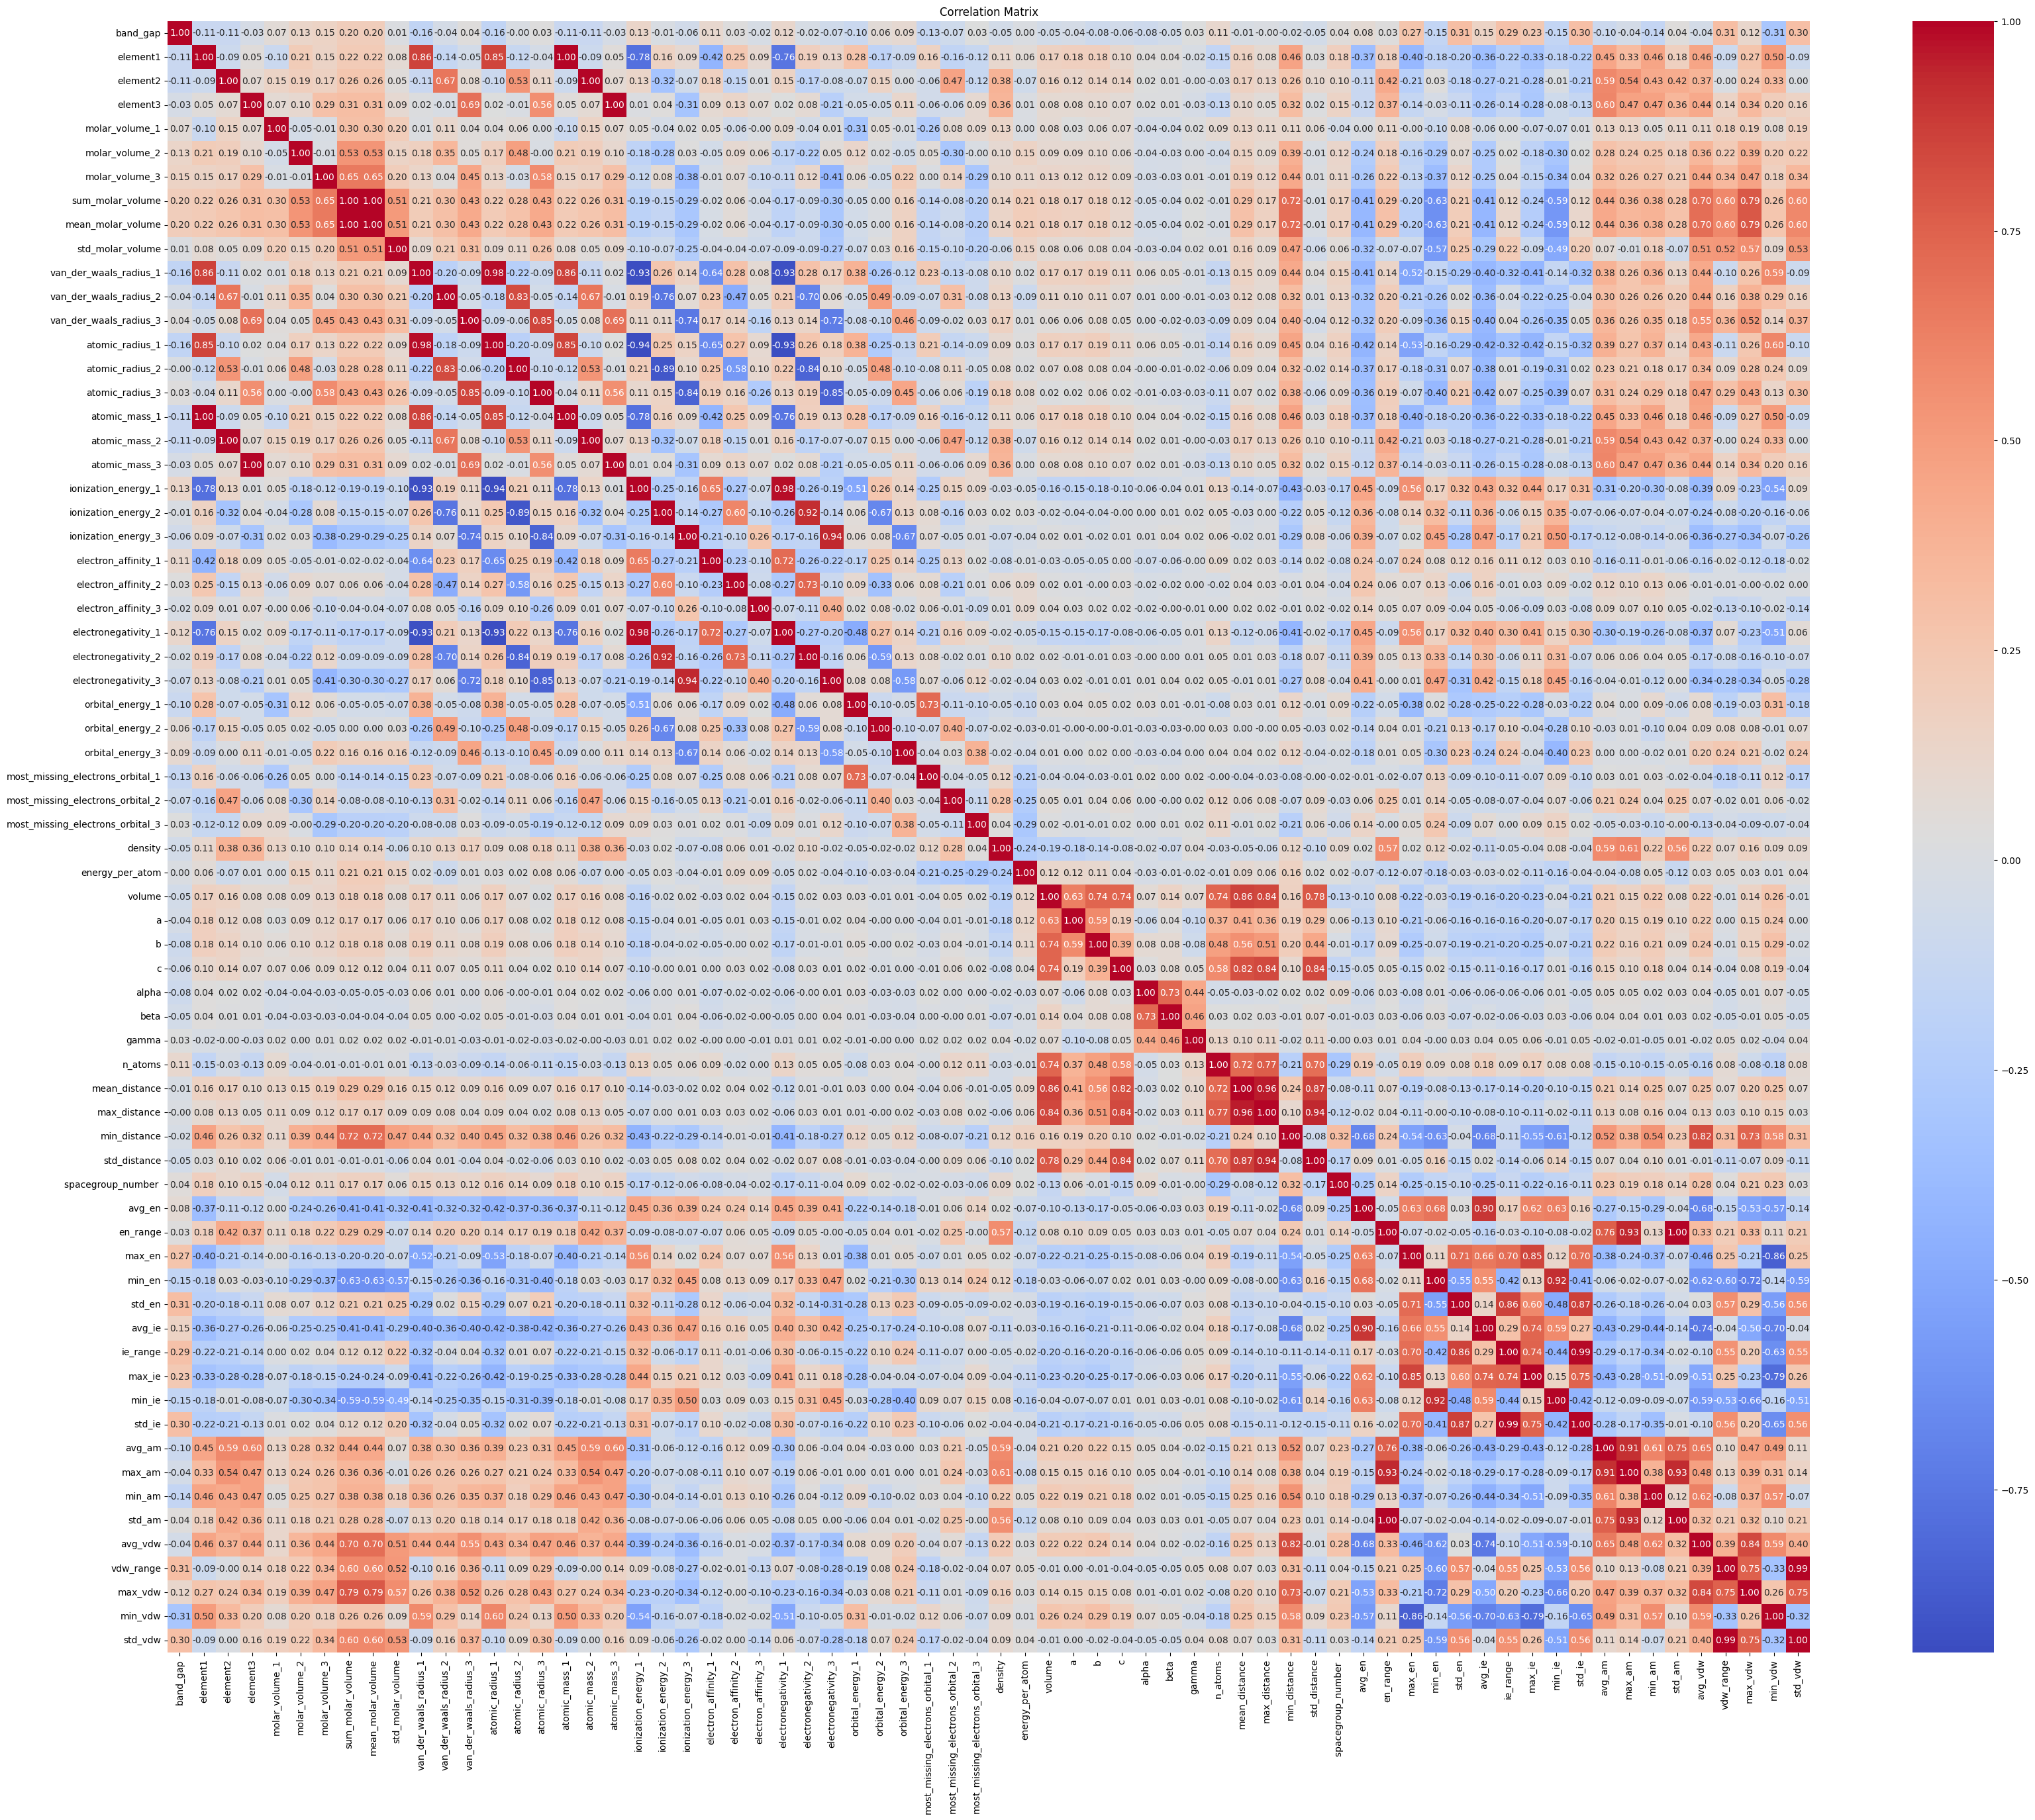

In [31]:
plt.figure(figsize=(40, 32))
sns.heatmap(df_copy.corr(method = 'spearman', numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.savefig('correlation_matrix_3el.png')